In [13]:
%load_ext autoreload
%autoreload 2
import sys
import os
from decimal import *
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import allantools
import scipy 

sys.path.append('../../qerr')
sys.path.append('qerr')
sys.path.append('quabo/pano_software')
sys.path.append('quabo/pano_software/util')

from dgnss_utils import panoseti_file_interfaces as pfi
from dgnss_utils import pff
from qerr_utils import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
def load_ph_data(data_dir, run_dir, module_id):
    """
    Create a pd.DataFrame containing the header information of every PH event in data_dir/run_dir for module_id.
    """
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return
    columns = [
        'wr_timestamp (s)',
        'quabo_num',
        'pkt_num',
        'pkt_tai',
        'pkt_nsec',
        'tv_sec',
        'tv_usec',
        # 'img_data'
    ]
    ph_df = pd.DataFrame(columns=columns)
    
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in tqdm(frame_iterator):
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                # j['img_data'] = img
                ph_df.loc[len(ph_df)] = j
    ph_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
    ph_df = ph_df.sort_values(by='wr_timestamp (s)')
    return ph_df


def load_qerr_df(fpath):
    """
    Load the pd.DataFrame containing quantization error (qerr) data produced by qerr/capture_qerr.py
    """
    df = load_data(fpath)
    df['unix_timestamp'] = pd.to_datetime(df['pkt_unix_timestamp_TIM-TP'], unit='ns')
    # qerr data timestamps are in pacific time
    df['unix_timestamp'] = df['unix_timestamp'].dt.tz_localize('US/Pacific').dt.tz_convert('utc')
    df['qErr (ns)'] = df['qErr (ps)'] * 1e-3
    df = df.sort_values(by='unix_timestamp')
    return df


def align_data(q0, qerr0, q1, qerr1):
    """
    Aligns PH-event and qerr pd.DataFrames to their earliest and latest common timestamps. 
    """
    tsts = {
        'q0': q0,
        'qerr0': qerr0,
        'q1': q1,
        'qerr1': qerr1,
    }
    ealiest_common_timestamp = max(map(lambda s: s['unix_timestamp'].round('ms').min(), tsts.values()))
    latest_common_timestamp = min(map(lambda s: s['unix_timestamp'].round('ms').max(), tsts.values()))

    def trim(df):
        start_idx = np.searchsorted(df['unix_timestamp'], ealiest_common_timestamp, side='right')
        end_idx = np.searchsorted(df['unix_timestamp'], latest_common_timestamp, side='left')
        return df.iloc[start_idx:end_idx].reset_index(drop=True)
        
    aq0, aqerr0, aq1, aqerr1 = trim(q0), trim(qerr0), trim(q1), trim(qerr1)
    new_len = min(len(aq0), len(aqerr0), len(aq1), len(aqerr1))
    return aq0[:new_len], aqerr0[:new_len], aq1[:new_len], aqerr1[:new_len]

## Utils for plotting FFT and plotting power spectrums
def plot_fft_data(fft_data, is_real=False, interactive=False, title=None):
    xlabel = "Hz"
    ylabel = r"log10(Power)"
    
    with np.errstate(divide='ignore'):
        max_rfreq_idx = np.argmax(fft_data['freqs'])   # Index of max real frequency
        if is_real:
            freqs = fft_data['freqs'][0:max_rfreq_idx + 1]
            power = np.log10(fft_data['power'][0:max_rfreq_idx + 1])
        else:
            freqs = np.roll(fft_data['freqs'], max_rfreq_idx)
            power = np.log10(np.roll(fft_data['power'], max_rfreq_idx))
            
    if interactive:
        fig = px.line(
            x = freqs,
            y = power,
            title=title,
            height=700
        )
        fig.update_layout(xaxis_title=xlabel,yaxis_title=ylabel)
        fig.show()
    else:
        # (rad / samp) * (1s / 2pi rad)
        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        fig = sns.lineplot(
            x = freqs,
            y = power,
            ax=ax
        )
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        ax.grid('on')

def apply_fft(x, T=None):
    next_largest_power_of_2 = int(2**(np.ceil(np.log2(len(x)))))
    windowed = np.pad(x, (0, next_largest_power_of_2 - len(x)))

    N = min(len(x), 2**15)       # FFT size
    
    sampling_period = 1

    X = np.fft.fft(x, N)

    freqs = np.fft.fftfreq(len(X), sampling_period) 
    PS = np.abs(X)**2
    fft_data = {
        'X': X,
        'freqs': freqs,
        'power': PS
    }   
    return fft_data

In [367]:
data_dir = 'field_timing_data'
#run_dir = 'obs_UCB_lab.start_2024-08-23T02:40:52Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-08-26T03:58:01Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-08-29T04:29:01Z.runtype_eng-test.pffd'
run_dir = 'obs_UCB_lab.start_2024-08-29T16:31:13Z.runtype_eng-test.pffd'
run_dir = 'obs_UCB_lab.start_2024-08-30T01:12:04Z.runtype_eng-test.pffd'
# run_dir = 'obs_UCB_lab.start_2024-08-31T15:47:25Z.runtype_eng-test.pffd'
# run_dir = 'obs_UCB_lab.start_2024-09-01T04:18:11Z.runtype_eng-test.pffd'
# run_dir = 'obs_UCB_lab.start_2024-09-03T15:58:34Z.runtype_eng-test.pffd'


qerr0_fpath = glob('%s/%s/qErr/*ttyS10/*MERGED*'%(data_dir,run_dir))[0]
qerr1_fpath = glob('%s/%s/qErr/*ttyUSB0/*MERGED*'%(data_dir,run_dir))[0]

timing0_file = glob('%s/%s/*dp_ph256*_*251*'%(data_dir, run_dir))[0]
timing1_file = glob('%s/%s/*dp_ph256*_*253*'%(data_dir, run_dir))[0]

print(qerr0_fpath.split('/')[-1])
print(qerr1_fpath.split('/')[-1])
print(timing0_file.split('/')[-1])
print(timing1_file.split('/')[-1])


qerr0 = load_qerr_df(qerr0_fpath)
q0 = load_ph_data(data_dir, run_dir, 251)

qerr1 = load_qerr_df(qerr1_fpath)
q1 = load_ph_data(data_dir, run_dir, 253)

pfi.ObservingRunInterface(data_dir, run_dir).obs_pff_files

data-type_MERGED.start_2024-08-29T18:11:27.230202
data-type_MERGED.start_2024-08-29T18:11:15.103059
start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_251.seqno_0.pff
start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_253.seqno_0.pff


44744it [00:31, 1418.15it/s]
27231it [00:15, 1764.61it/s]


{253: {'img': [],
  'ph': [{'fname': 'start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_253.seqno_0.pff',
    'seqno': 0,
    'nframes': 27231,
    'first_unix_t': Decimal('1724980338.602017134'),
    'last_unix_t': Decimal('1725007568.602017129')}]},
 251: {'img': [],
  'ph': [{'fname': 'start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_251.seqno_0.pff',
    'seqno': 0,
    'nframes': 44744,
    'first_unix_t': Decimal('1724980338.602017134'),
    'last_unix_t': Decimal('1725025081.602017132')}]}}

In [368]:
def compute_qerr_align_idx(quabo_df, qerr_df):
    """
    Cross-correlate the qerr (ns) corrections with the quabo nanosecond deviations from the first white rabbit unix timestamp.
    Returns the index by which the QERR data should be rolled (using np.roll) to best align the QERR and quabo timestamp data.
    """
    quabo_ns = quabo_df['wr_timestamp (s)'] - quabo_df['wr_timestamp (s)'][0] # Subtract unix start time
    quabo_ns = quabo_ns % 1    # Keep only the subsecond component
    quabo_ns = quabo_ns * 10**9  # Unit conversion: seconds to nanoseconds
    quabo_ns = quabo_ns.astype(np.float64)
    
    cross_corr = scipy.signal.correlate(quabo_ns, qerr_df['qErr (ns)'], 'full' )
    idx = np.argmax(cross_corr) - len(qerr_df) + 1
    # sns.lineplot(cross_corr)
    # plt.axvline(shift_amount, color='red')
    return idx

def align_qdata_and_qerr(quabo_df, qerr_df):
    idx = compute_qerr_align_idx(quabo_df, qerr_df)
    quabo_data = quabo_df
    qerr_data = qerr_df[-idx:]
    return quabo_data, qerr_data
    
# q0_data, qerr0_data = align_qdata_and_qerr(q0, qerr0)
# common_len = np.min((len(q0_data), len(qerr0_data)))

# sns.lineplot()

In [369]:
def align_data(q0, qerr0, q1, qerr1):
    """
    Aligns PH-event and qerr pd.DataFrames to their earliest and latest common timestamps. 
    """
    
    idx0 = compute_qerr_align_idx(q0, qerr0)
    idx1 = compute_qerr_align_idx(q1, qerr1)

    qerr0 = qerr0.iloc[-idx0:]
    qerr1 = qerr1.iloc[-idx1:]

    tsts = {
        'q0': q0,
        'qerr0': qerr0,
        'q1': q1,
        'qerr1': qerr1,
    }
    ealiest_common_timestamp = max(map(lambda s: s['unix_timestamp'].round('ms').min(), tsts.values()))
    latest_common_timestamp = min(map(lambda s: s['unix_timestamp'].round('ms').max(), tsts.values()))

    def trim(df):
        start_idx = np.searchsorted(df['unix_timestamp'], ealiest_common_timestamp, side='right')
        end_idx = np.searchsorted(df['unix_timestamp'], latest_common_timestamp, side='left')
        return df.iloc[start_idx:end_idx].reset_index(drop=True)
        
    aq0, aqerr0, aq1, aqerr1 = trim(q0), trim(qerr0), trim(q1), trim(qerr1)
    new_len = min(len(aq0), len(aqerr0), len(aq1), len(aqerr1))
    return aq0[:new_len], aqerr0[:new_len], aq1[:new_len], aqerr1[:new_len]

<Axes: ylabel='quabo_wr_diffs (ns)'>

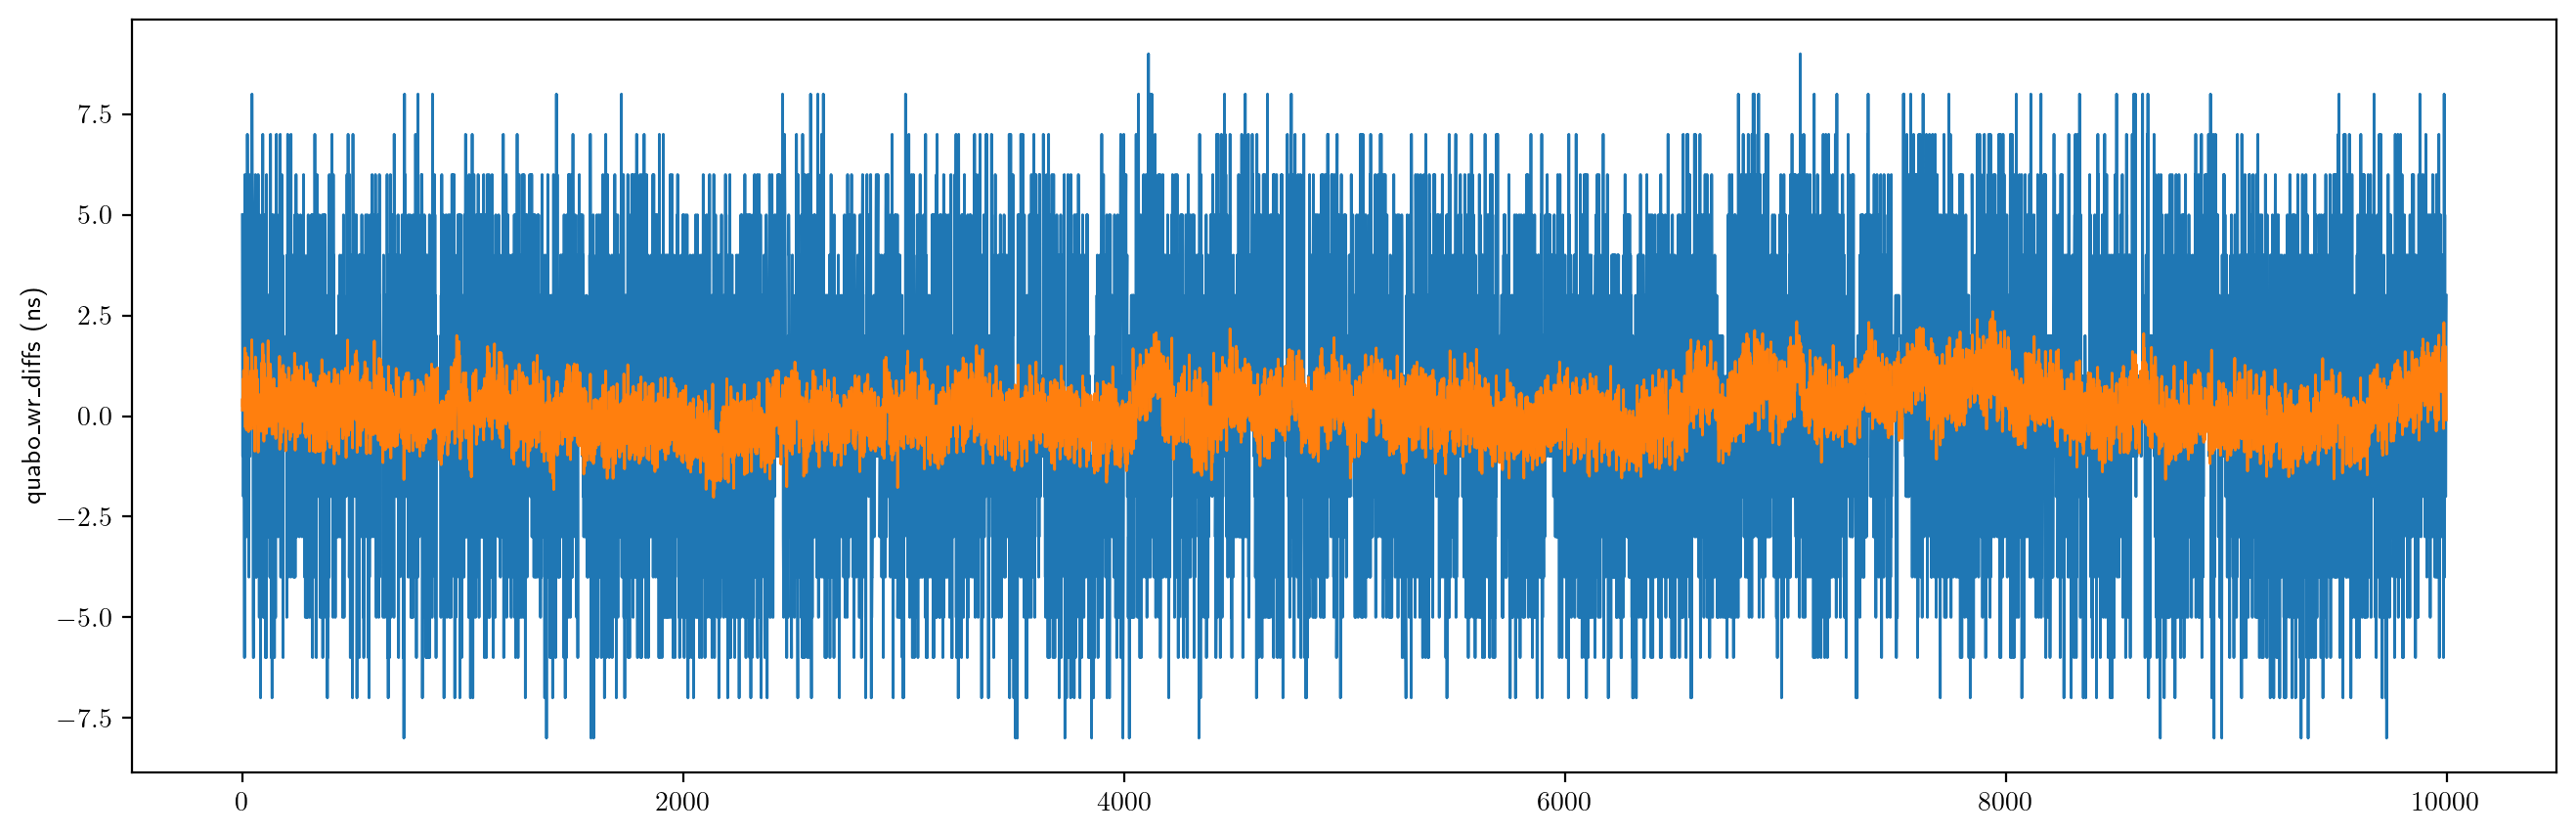

In [370]:
# Align data
aq0, aqerr0, aq1, aqerr1 = align_data(q0, qerr0, q1, qerr1)

# for df in [aq0, aqerr0, aq1, aqerr1]:
#     ...
#     print(len(df))
#     print(df['unix_timestamp'].iloc[0].round('ms'))
#     print(df['unix_timestamp'].iloc[-1].round('ms'))

# Compute differences

diffs = pd.DataFrame(columns=['quabo_wr_diffs', 'qerr_diffs', 'quabo_wr_diffs_without_qerrs'])

diffs['quabo_wr_diffs (ns)'] = ((aq0['wr_timestamp (s)'] - aq1['wr_timestamp (s)']) * 10**9).astype(np.float64)  # Do second -> nanosecond conversion with Decimal to elimiate floating-point errors
diffs['qerr_diffs (ns)'] = (aqerr1['qErr (ns)'] - aqerr0['qErr (ns)'])
diffs['quabo_wr_diffs_without_qerrs (ns)'] = diffs['quabo_wr_diffs (ns)'] - np.roll(diffs['qerr_diffs (ns)'], 0)

trim = 10000
plt.figure(figsize=(16,5), dpi=200)
sns.lineplot(diffs['quabo_wr_diffs (ns)'].iloc[:trim], linewidth=1)
sns.lineplot(diffs['quabo_wr_diffs_without_qerrs (ns)'].iloc[:trim], linewidth=1)

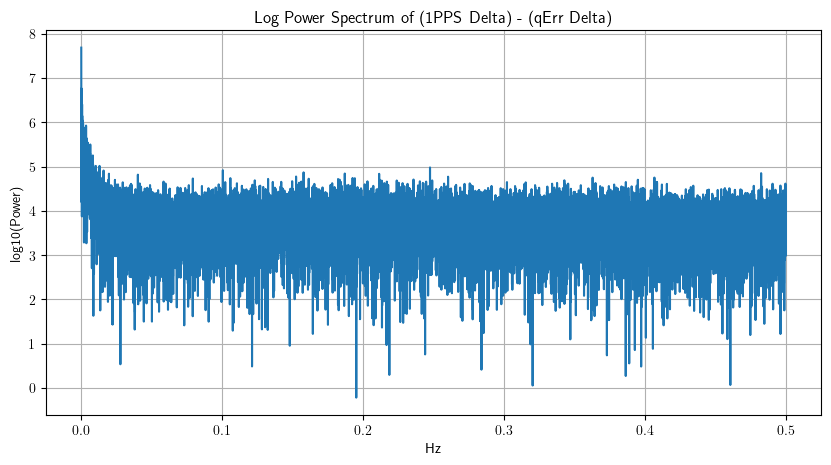

In [371]:
y_delta_no_qerr = diffs['quabo_wr_diffs_without_qerrs (ns)']
fft_data = apply_fft(y_delta_no_qerr)
plot_fft_data(fft_data, is_real=True, interactive=False, title=f'Log Power Spectrum of (1PPS Delta) - (qErr Delta)')

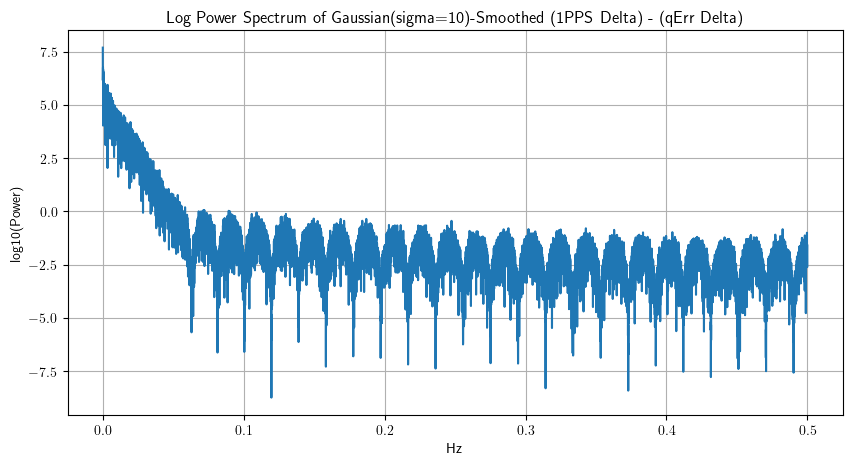

In [372]:
def apply_gaussian_kernel(data, sigma):
    gaussian_kernel = scipy.signal.windows.gaussian(5 * sigma + 1, sigma)
    gaussian_kernel = gaussian_kernel / np.sum(gaussian_kernel)
    # sns.lineplot(gaussian_kernel)
    
    y_delta_no_qerr_smoothed = scipy.signal.fftconvolve(gaussian_kernel, y_delta_no_qerr, mode='full')
    
    return y_delta_no_qerr_smoothed#[:len(data)]

sigma = 10
y_delta_no_qerr_smoothed = apply_gaussian_kernel(y_delta_no_qerr, sigma)
fft_data = apply_fft(y_delta_no_qerr_smoothed)
plot_fft_data(fft_data, is_real=True, interactive=False, title=f'Log Power Spectrum of Gaussian(sigma={sigma})-Smoothed (1PPS Delta) - (qErr Delta)')

In [380]:
def plot_timing_data(interactive=False):
    start_timestamp = aq0['unix_timestamp'][0].isoformat()
    total_time = len(aq0)
    
    title = f'1PPS Delta (ns) vs Elapsed Time (s); start = {start_timestamp}'
    xlabel = 'Elapsed Time (s)'
    ylabel = 'Time Delta (ns)'

    ### Create plotting dataframe
    plt_data = {
        "(1PPS Delta) - (qErr Delta)": diffs['quabo_wr_diffs_without_qerrs (ns)'],
    }

    # Apply smoothing filter
    longest_len = len(diffs)
    for sigma in 2**np.arange(7, 13, 1):
        y_delta_no_qerr_smoothed = apply_gaussian_kernel(diffs['quabo_wr_diffs_without_qerrs (ns)'], sigma)
        smoothed_title = rf'Gaussian(sigma={sigma})'
        plt_data[smoothed_title] = y_delta_no_qerr_smoothed
        longest_len = max(longest_len, len(y_delta_no_qerr_smoothed))
        
    # Equalize array sizes
    for key in plt_data.keys():
        plt_data[key] = np.resize(plt_data[key], longest_len)

    plt_df = pd.DataFrame.from_dict(plt_data)

    t_low = 0


    if interactive:
        fig = px.line(
            plt_df,
            x = plt_df.index,
            y = plt_df.columns,
            height=600,
            width=1200,
            title=title,
        )
        fig.update_layout(xaxis_title=xlabel, yaxis_title=ylabel)
        fig.show()
    else:
        f = plt.figure(figsize=(16, 7), dpi=100)
        ax = plt.gca()
        sns.lineplot(plt_df, linewidth=2)
            
        # Style axis
        xtick_spacing = total_time // 10
        xticks = np.linspace(t_low, longest_len, 20).astype(int)
        xticks = xticks - xticks % 100
        ax.set_xticks(xticks)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.set_title(title)

In [ ]:
plot_timing_data(interactive=False)

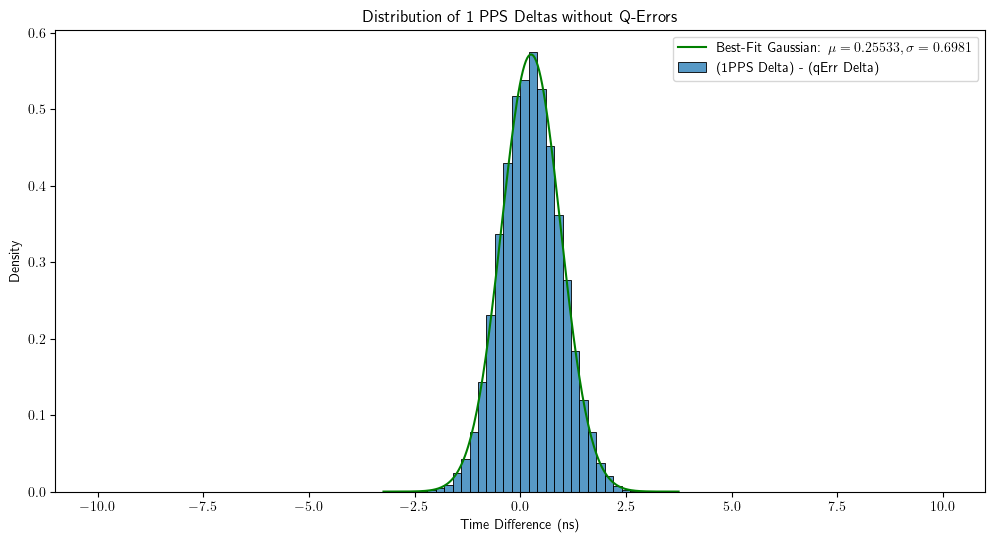

D'Agostino and Pearson's normality test: 
	pvalue =  0.18567654237698256


In [377]:
plt.figure(figsize=(12,6))
plt.rcParams['text.usetex'] = True


# Fit a gaussian to the qErr-corrected deltaT data
mu, sigma = scipy.stats.norm.fit(diffs['quabo_wr_diffs_without_qerrs (ns)'])
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 200)
gaussian_fit_quabo_wr_diffs_without_qerrs = scipy.stats.norm.pdf(x, mu, sigma)


# Plot histograms & Gaussian of best fit
bins = 100
binrange=[-10, 10]

# sns.histplot(diffs['quabo_wr_diffs (ns)'], stat='density', label='1PPS Delta', bins=bins, binrange=binrange);
sns.histplot(diffs['quabo_wr_diffs_without_qerrs (ns)'], stat='density', label='(1PPS Delta) - (qErr Delta)', bins=bins, binrange=binrange);
# sns.histplot(y_delta_no_qerr_smoothed, stat='density', label='Gaussian-smoothed (1PPS Delta) - (qErr Delta)', bins=bins, binrange=binrange);

sns.lineplot(x=x, y=gaussian_fit_quabo_wr_diffs_without_qerrs, label=f'Best-Fit Gaussian: $\\mu={mu:.5}, \\sigma={sigma:.5}$', c='g')

plt.legend()
plt.title('Distribution of 1 PPS Deltas without Q-Errors')
plt.xlabel('Time Difference (ns)');
plt.show()

# D'Agostino and Pearson's normality test
normality_test = scipy.stats.normaltest(diffs['quabo_wr_diffs_without_qerrs (ns)'])
print(f"D'Agostino and Pearson's normality test: \n\tpvalue = {normality_test.pvalue:>20}");

In [15]:
# for i in range(10000):
#     g = np.random.randn(10000)
    
#     p = scipy.stats.normaltest(g).pvalue
#     if p < 1e-4:
#         print(p)
# scipy.stats.normaltest(diffs['quabo_wr_diffs_without_qerrs (ns)'])

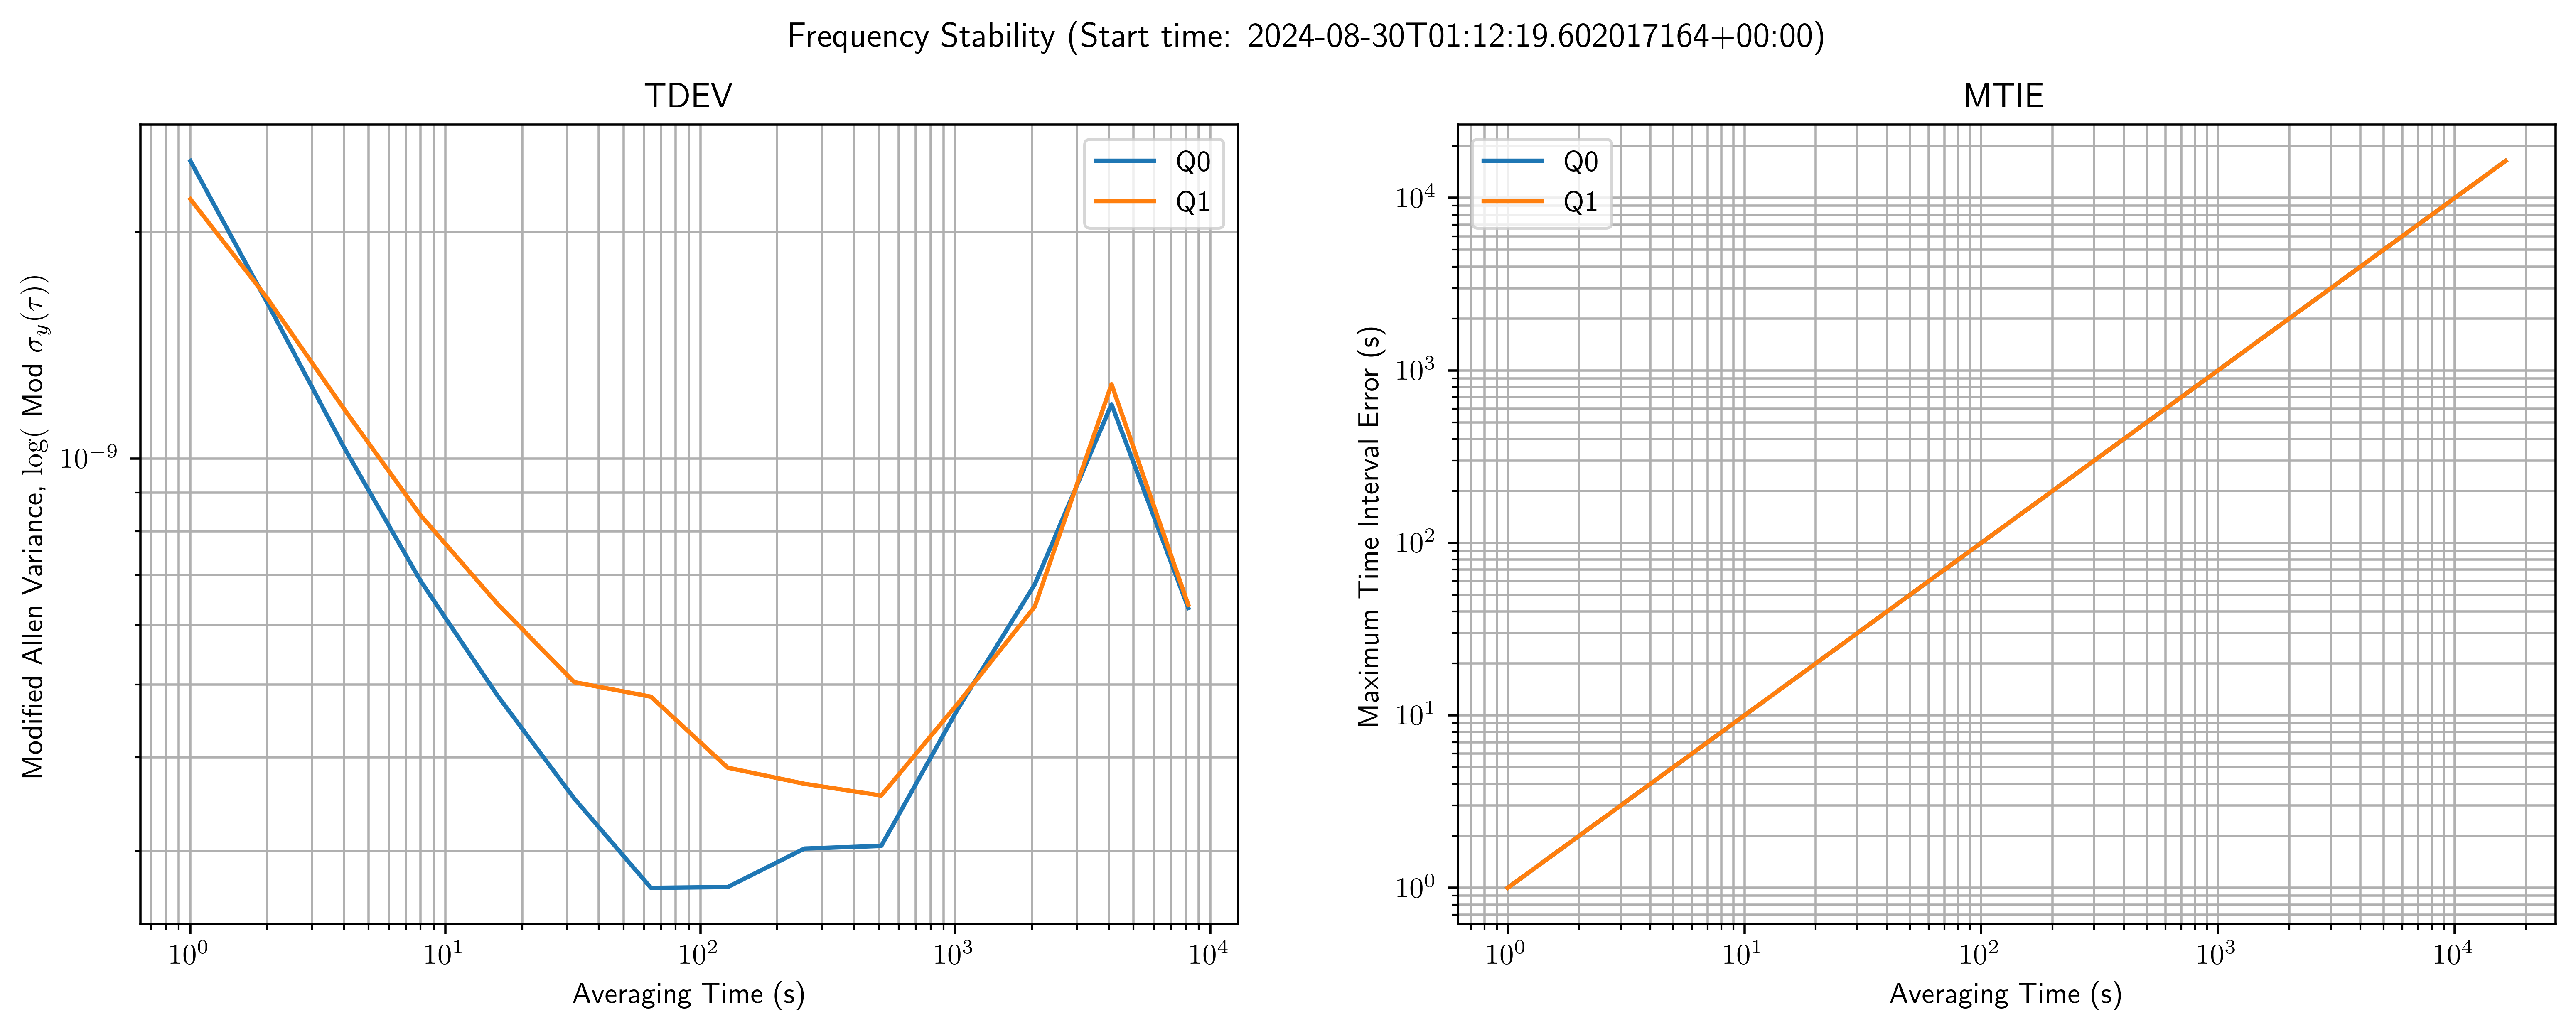

In [15]:
# Code for testing TIE
def get_clkerr(quabo_data):
    ideal_clock_period = 1
    clkerr = pd.DataFrame(columns = ['ideal clk time', 'actual clk time', 'actual clk period', 'period change', 'time interval error'])
    clkerr['ideal clk time'] = np.arange(len(quabo_data))
    clkerr['actual clk time'] = (quabo_data['wr_timestamp (s)'] - quabo_data['wr_timestamp (s)'].min()).astype(np.float64)
    clkerr['time interval error (s)'] = clkerr['actual clk time'] - clkerr['ideal clk time']
    clkerr['actual clk period (s)'] = clkerr['actual clk time'].diff()
    clkerr['period change'] = clkerr['actual clk period'].diff()
    return clkerr

clkerr0 = get_clkerr(aq0)
clkerr1 = get_clkerr(aq1)
# print(clkerr0['actual clk period (s)'].describe(), '\n' * 2, clkerr1['actual clk period (s)'].describe())

tdev_taus0, tdev0, tdev_error0, tdev_ns0 = allantools.tdev(clkerr0['actual clk time'])#, taus = "all")
mtie_taus0, mtie0, mtie_error0, mtie_ns0 = allantools.mtie(clkerr0['actual clk time'])#, taus = "all")

tdev_taus1, tdev1, tdev_error1, tdev_ns1 = allantools.tdev(clkerr1['actual clk time'])#, taus = "all")
mtie_taus1, mtie1, mtie_error1, mtie_ns1 = allantools.mtie(clkerr1['actual clk time'])#, taus = "all")

f, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=500)
f.suptitle(f'Frequency Stability (Start time: {start_timestamp})')

sns.lineplot(x=tdev_taus0, y=tdev0, ax=axs[0], label='Q0')
sns.lineplot(x=tdev_taus1, y=tdev1, ax=axs[0], label='Q1')

sns.lineplot(x=mtie_taus0, y=mtie0, ax=axs[1], label='Q0')
sns.lineplot(x=mtie_taus1, y=mtie1, ax=axs[1], label='Q1')

plt.rcParams['text.usetex'] = True
for ax in axs:
    ax.set_xlabel('Averaging Time (s)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='both')

axs[0].set_title('TDEV')
axs[0].set_ylabel(f'Modified Allen Variance, $\\log($ Mod $\\sigma_y(\\tau))$')

axs[1].set_title('MTIE')
axs[1].set_ylabel('Maximum Time Interval Error (s)');

In [16]:
adev_taus_diff, adev_diff, adev_error_diff, adev_ns_diff = allantools.adev(diffs['quabo_wr_diffs_without_qerrs (ns)'])#, taus = "all")
tdev_taus_diff, tdev_diff, tdev_error_diff, tdev_ns_diff = allantools.tdev(diffs['quabo_wr_diffs_without_qerrs (ns)'])#, taus = "all")
mtie_taus_diff, mtie_diff, mtie_error_diff, mtie_ns_diff = allantools.mtie(diffs['quabo_wr_diffs_without_qerrs (ns)'])#, taus = "all")

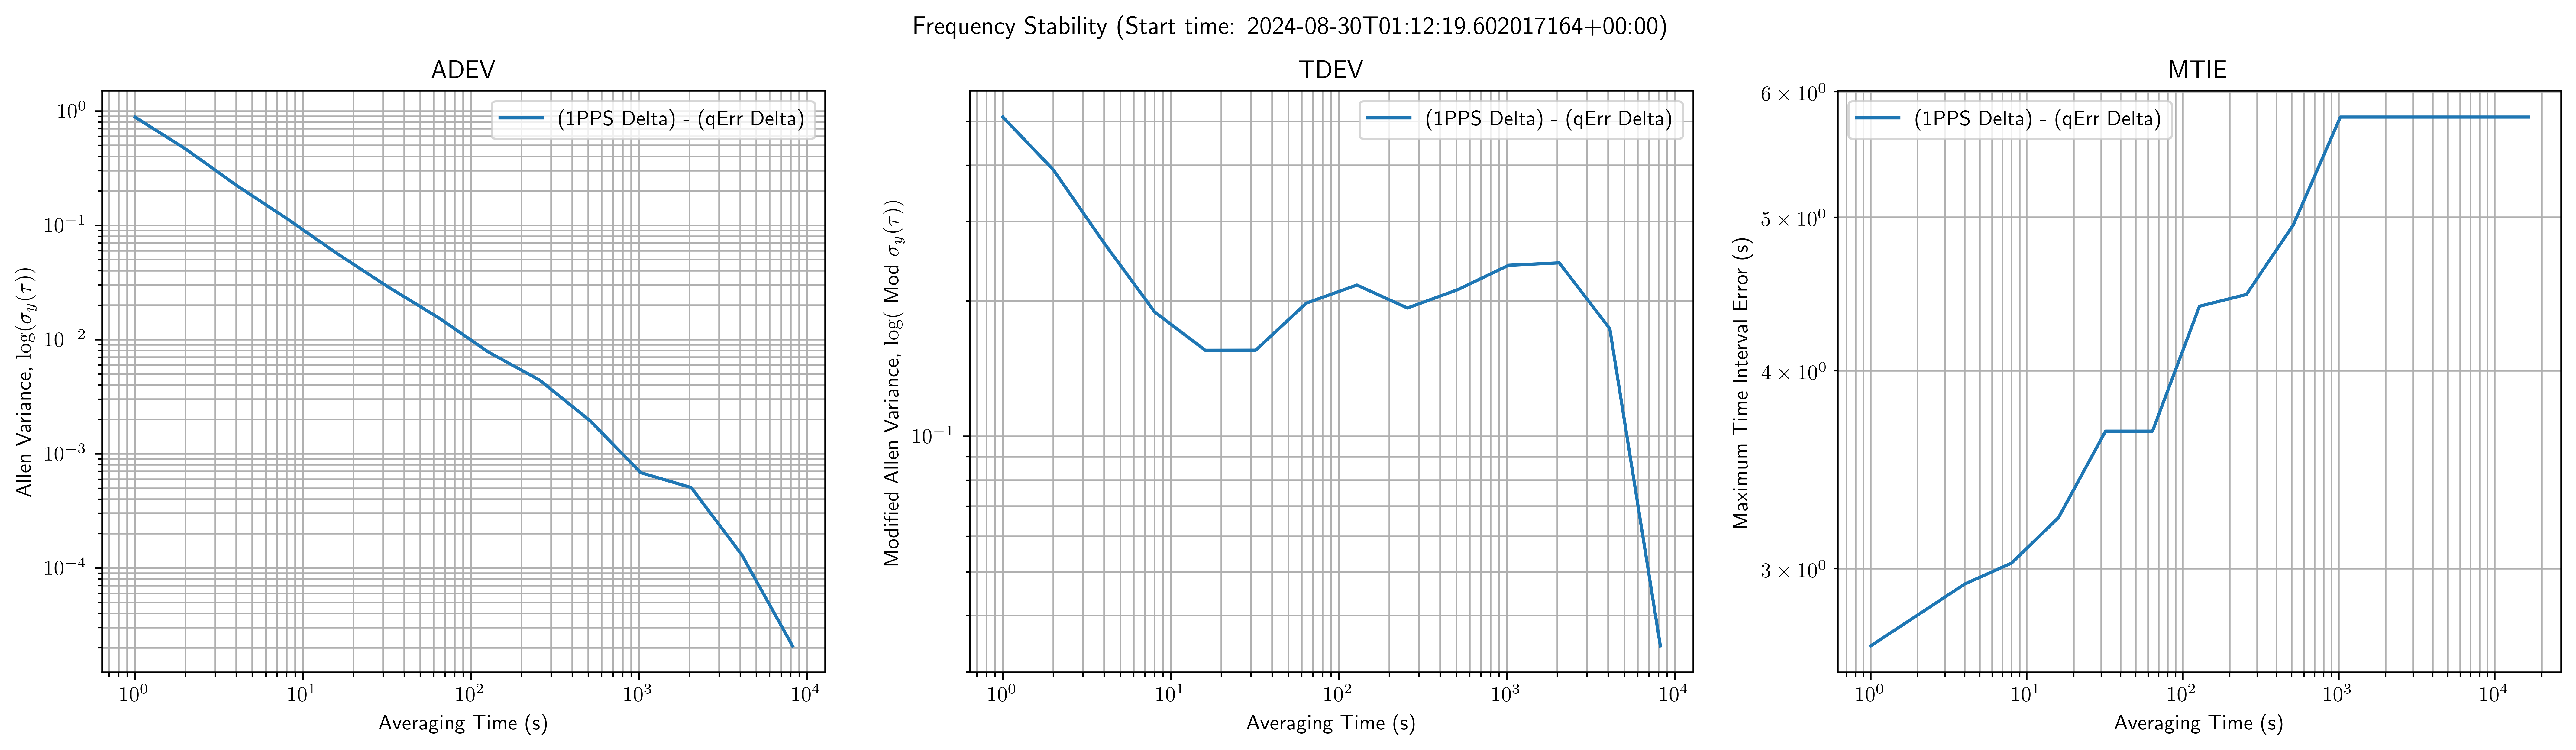

In [17]:
f, axs = plt.subplots(1, 3, figsize=(21, 5), dpi=500)
f.suptitle(f'Frequency Stability (Start time: {start_timestamp})')

sns.lineplot(x=adev_taus_diff, y=adev_diff, ax=axs[0], label='(1PPS Delta) - (qErr Delta)')
sns.lineplot(x=tdev_taus_diff, y=tdev_diff, ax=axs[1], label='(1PPS Delta) - (qErr Delta)')
sns.lineplot(x=mtie_taus_diff, y=mtie_diff, ax=axs[2], label='(1PPS Delta) - (qErr Delta)')


plt.rcParams['text.usetex'] = True
for ax in axs:
    ax.set_xlabel('Averaging Time (s)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='both')

axs[0].set_title('ADEV')
axs[0].set_ylabel(f'Allen Variance, $\\log(\\sigma_y(\\tau))$')

axs[1].set_title('TDEV')
axs[1].set_ylabel(f'Modified Allen Variance, $\\log($ Mod $\\sigma_y(\\tau))$')

axs[2].set_title('MTIE')
axs[2].set_ylabel('Maximum Time Interval Error (s)');